# Clustering

Reference:
    https://isaac-flath.github.io/TechBlog/posts/K-Means/ClusteringFromScratch.html

Clustering techniques are unsupervised learning algorithms that try to group unlabelled data into "clusters" using the structure of the data itself.

Demonstrate how clustering works is by generating some data & show them in action.

There is no dependent variable here.

In [ ]:
import fastcore.all as fc

In [ ]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [ ]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Create data

In [ ]:
n_clusters=6
n_samples=250

To generate data, pick 6 random points (centroids) and for each point, generate 250 random points about it.

In [ ]:
centroids = torch.rand(n_clusters, 2)*70-35 # points between -35 and 35

In [ ]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [ ]:
torch.diag(tensor([5.,5.]))

tensor([[5., 0.],
        [0., 5.]])

In [ ]:
#mean for x and mean for y
def sample(m): return MultivariateNormal(m, covariance_matrix=torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [ ]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

In [ ]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

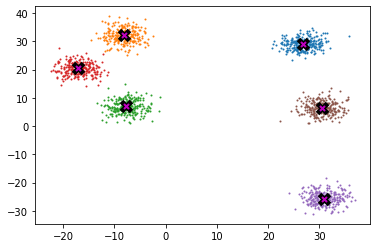

In [ ]:
plot_data(centroids, data, n_samples)

## Meanshift

Task: Start with all dots and find where all the x's are

Adv:
- Does not require selecting clusters in advance but instead just require a **bandwidth** to be specified which can be easily chosen automatically
- It can handle clusters of any shape, whereas k-means (without using special extension) requires that clusters be roughly ball shaped.

The algorithm is as follows:
* For each data point x in the sample X, find the distance between that point x and every other point in X
* Create weights for each point in X by using the **Gaussian kernel** of that point's distance to x
    * This weighting approach penalizes points further away from x
    * The rate at which the weights fall to zero is determined by the **bandwidth**, which is the standard deviation of the Gaussian
* Update x as the weighted average of all other points in X, weighted based on the previous step

This will iteratively push points that are close together even closer until they are next to each other.

In [ ]:
data, data.shape # mean along 0th dimension ie (26.204 + 25.691)..../1500

(tensor([[26.204, 26.349],
         [25.691, 30.213],
         [30.431, 28.693],
         ...,
         [30.772,  9.323],
         [29.354,  3.960],
         [31.168,  5.309]]),
 torch.Size([1500, 2]))

In [ ]:
midp = data.mean(0);midp

tensor([ 9.222, 11.604])

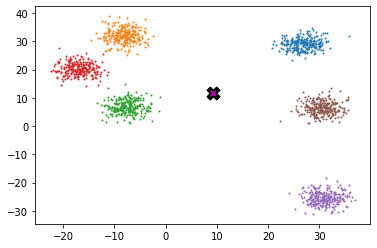

In [ ]:
plot_data([midp]*6, data, n_samples)

definition of gaussian kernel <img src="http://i.imgur.com/nijQLHw.jpg" width=400>. It is also known as normal distribution.

In [ ]:
def gaussian(d, bw): return torch.exp(-0.5*((d/bw)**2)) / (bw*math.sqrt(2*math.pi))

In [ ]:
def plot_func(f):
    x = torch.linspace(-10, 10, 100) # start, end, steps
    plt.plot(x, f(x))

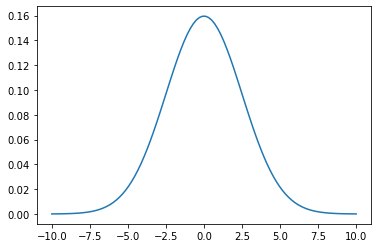

In [ ]:
plot_func(partial(gaussian, bw=2.5))

In [ ]:
def plot_func(f):
    x = torch.linspace(0, 10, 100) # start, end, steps
    plt.plot(x, f(x))

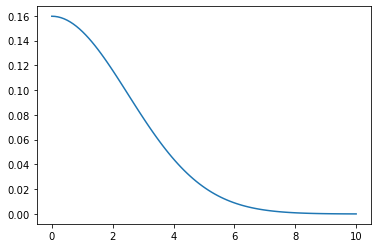

In [ ]:
plot_func(partial(gaussian, bw=2.5))

In [ ]:
partial # aka currying or partial func application

functools.partial

Another way

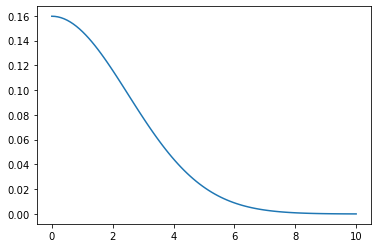

In [ ]:
plot_func(lambda x: gaussian(x,bw=2.5))

bandwidth is chosen as 2.5. Why? . Choose a bw that covers a third of data.

In [ ]:
def tri(d, i): return (-d+i).clamp_min(0)/i

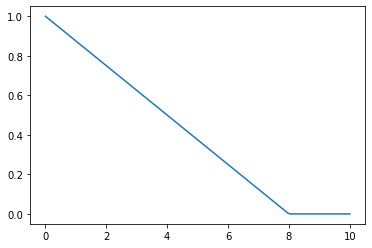

In [ ]:
plot_func(partial(tri,i=8))

In [ ]:
X = data.clone()
x = data[0];x

tensor([26.204, 26.349])

In [ ]:
x.shape, X.shape, x[None].shape

(torch.Size([2]), torch.Size([1500, 2]), torch.Size([1, 2]))

In [ ]:
(x - X)[:8] # last axis matches 2nd last axis does not exist so let's pretend there is unit axis

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        [ 0.557, -3.685],
        [-5.033, -3.745],
        [-4.073, -0.638],
        [-3.415, -5.601],
        [-1.920, -5.686]])

Norm is also known as euclidean distance.

MAE -> L1 norm. RMSE -> L2 norm

In [ ]:
dist = ((x-X)**2).sum(1).sqrt();dist

tensor([ 0.000,  3.899,  4.834,  ..., 17.628, 22.610, 21.617])

From [A basic introduction to NumPy's einsum](https://ajcr.net/Basic-guide-to-einsum/)
Three rules of einstein summation
- Repeating letters between input arrays means that values along those axes will be multiplied together. The products make up the values for the output array.
- Omitting a letter from the output means that values along that axis will be summed.
- We can return the unsummed axes in any order we like.

In [ ]:
#rewrite the above using einsum
torch.einsum('ij,ij->i', (x-X), (x-X)).sqrt()

tensor([ 0.000,  3.899,  4.834,  ..., 17.628, 22.610, 21.617])

In [ ]:
weight = gaussian(dist, 2.5);weight

tensor([    0.160,     0.047,     0.025,  ...,     0.000,     0.000,     0.000])

In [ ]:
weight.shape, X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

Weighted average = sum(prod(w,x) / sum(w)

In [ ]:
weight[:,None].shape # add the trailing unit axis in order to mulitply X

torch.Size([1500, 1])

In [ ]:
(weight[:,None]*X)[:4]

tensor([[4.182, 4.205],
        [1.215, 1.429],
        [0.749, 0.706],
        [1.347, 1.578]])

In [ ]:
(weight[:,None]*X)[:4].sum(0) #columnwise

tensor([7.493, 7.918])

In [ ]:
(weight[:,None]*X)[:4].sum(1) # rowwise

tensor([8.386, 2.645, 1.455, 2.925])

In [ ]:
def one_update(X):
    for i,x in enumerate(X):
        dist = torch.einsum('ij,ij->i', (x-X), (x-X)).sqrt()
        weight = gaussian(dist, 2.5)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [ ]:
def meanshift(data):
    X = data.clone()
    for i in range(5): one_update(X)
    return X

In [ ]:
%time X=meanshift(data)

CPU times: user 5.22 s, sys: 6.21 ms, total: 5.22 s
Wall time: 1.32 s


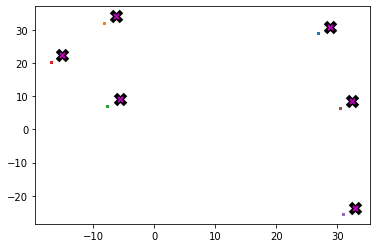

In [ ]:
plot_data(centroids+2, X, n_samples)

## Animation

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [ ]:
def do_one(d):
    if d: one_update(X)
    ax.clear() # without this it prints it on top of the other
    plot_data(centroids+2, X, n_samples, ax=ax)

In [ ]:
X = data.clone()
fig,ax=plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

## GPU batched algorithm

To accelerate the algorithm, perform update on a batch of points per iteration instead of just one

In [ ]:
bs = 5
X = data.clone()
x = X[:bs] # first 5 items
x.shape,X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

Previously the distance calculation `dist = ((x-X)**2).sum(1).sqrt()
` only worked with single number. But we want something to return a matrix ie `5 X 2 @ 1500 X 2 -> 5 X 1500`.

In [ ]:
(x-X)

RuntimeError: The size of tensor a (5) must match the size of tensor b (1500) at non-singleton dimension 0

This is because from right to left 2 matches but 5 and 1500 did not match.

In [ ]:
x[:, None].shape, X[None, :].shape, (x[:,None] - X[None,:]).shape

(torch.Size([5, 1, 2]), torch.Size([1, 1500, 2]), torch.Size([5, 1500, 2]))

`torch.sqrt(tensor)` is equivalent to `tensor.sqrt()`

In [ ]:
def dist_b(a,b): return (((a[None]-b[:,None])**2).sum(2)).sqrt()

In [ ]:
dist_b(X, x).shape

torch.Size([5, 1500])

Now we have determined for each data point x in the sample X, the distance between that point x and every other point in X is identified.

Let's create weights for each point in X by using the Gaussian kernel of that point's distance to x
`def gaussian(d, bw): return torch.exp(-0.5*((d/bw)**2)) / (bw*math.sqrt(2*math.pi))`

In [ ]:
weight = gaussian(dist_b(X, x), 2)
weight

tensor([[    0.199,     0.030,     0.011,  ...,     0.000,     0.000,     0.000],
        [    0.030,     0.199,     0.009,  ...,     0.000,     0.000,     0.000],
        [    0.011,     0.009,     0.199,  ...,     0.000,     0.000,     0.000],
        [    0.035,     0.199,     0.009,  ...,     0.000,     0.000,     0.000],
        [    0.001,     0.004,     0.144,  ...,     0.000,     0.000,     0.000]])

In [ ]:
weight.shape, X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

In [ ]:
# Both are equivalent for adding unit axis at the end
fc.test_eq(weight[:,:, None].shape, torch.Size([5, 1500, 1]))
fc.test_eq(weight[..., None].shape, torch.Size([5, 1500, 1]))

In [ ]:
X[None].shape, weight[..., None].shape 

(torch.Size([1, 1500, 2]), torch.Size([5, 1500, 1]))

In [ ]:
(weight[..., None] * X[None]).shape

torch.Size([5, 1500, 2])

In [ ]:
num = (weight[..., None] * X[None]).sum(1) # sum up over 1500 points
num.shape

torch.Size([5, 2])

In [ ]:
num

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.217],
        [231.302, 234.155]])

When you see a product and sum, then we may need to use einsum

In [ ]:
torch.einsum('ij,jk->ik', weight, X)

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.217],
        [231.302, 234.155]])

In [ ]:
weight @ X

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.217],
        [231.302, 234.155]])

In [ ]:
weight, weight.shape

(tensor([[    0.199,     0.030,     0.011,  ...,     0.000,     0.000,     0.000],
         [    0.030,     0.199,     0.009,  ...,     0.000,     0.000,     0.000],
         [    0.011,     0.009,     0.199,  ...,     0.000,     0.000,     0.000],
         [    0.035,     0.199,     0.009,  ...,     0.000,     0.000,     0.000],
         [    0.001,     0.004,     0.144,  ...,     0.000,     0.000,     0.000]]),
 torch.Size([5, 1500]))

denominator is the sum of weights

In [ ]:
weight.sum(1)

tensor([13.947, 19.859, 11.410, 20.238,  7.888])

In [ ]:
div = weight.sum(1, keepdim=True); div

tensor([[13.947],
        [19.859],
        [11.410],
        [20.238],
        [ 7.888]])

In [ ]:
num.shape, div.shape

(torch.Size([5, 2]), torch.Size([5, 1]))

In [ ]:
num/div

tensor([[26.376, 27.692],
        [26.101, 29.643],
        [28.892, 28.990],
        [26.071, 29.559],
        [29.323, 29.685]])

In [ ]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone
    for it in range(5):
        for i in range(0, n ,bs):
            s = slice(i, min(i+bs,n))
            weight = gaussian(dist_b(X, X[s]), 2.5)
            div = weight.sum(1, keepdim=True)
            X[x] = weight@X/div
    return X

In [ ]:
# data = data.cuda()

In [ ]:
# X = meanshift(data).cpu()

TypeError: 'builtin_function_or_method' object is not subscriptable

In [ ]:
# %timeit -n 5 _=meanshift(data, 1250).cpu()

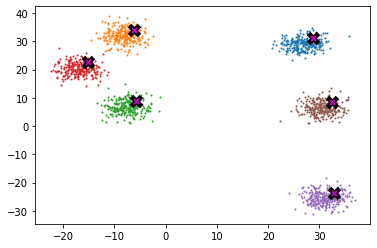

In [ ]:
plot_data(centroids+2, X, n_samples)

**Homework:** implement [k-means](https://realpython.com/k-means-clustering-python/) clustering, [dbscan](https://www.kdnuggets.com/2020/04/dbscan-clustering-algorithm-machine-learning.html), [locality sensitive hashing](https://www.pinecone.io/learn/locality-sensitive-hashing/), or some other clustering, fast nearest neighbors, or similar algorithm of your choice, on the GPU. Check if your version is faster than a pure python or CPU version.